<ipython-input-2-94d8eedc9b4f>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Dataset Overview:
root
 |-- order_id: string (nullable = false)
 |-- customer_id: string (nullable = false)
 |-- order_date: date (nullable = false)
 |-- product_id: string (nullable = false)
 |-- quantity: integer (nullable = false)
 |-- unit_price: double (nullable = false)
 |-- category: string (nullable = false)


Total Records: 10

Overall Sales Metrics:
+------------+-------------+---------------+
|total_orders|total_revenue|avg_order_value|
+------------+-------------+---------------+
|          10|       2450.0|          245.0|
+------------+-------------+---------------+


Category-wise Analysis:
+-----------+----------------+-------+---------------+
|   category|number_of_orders|revenue|avg_order_value|
+-----------+----------------+-------+---------------+
|Electronics|               6| 1200.0|          200.0|
|  Furniture|               2|  800.0|          400.0|
|   Clothing|               2|  450.0|          225.0|
+-----------+----------------+-------+---------------+




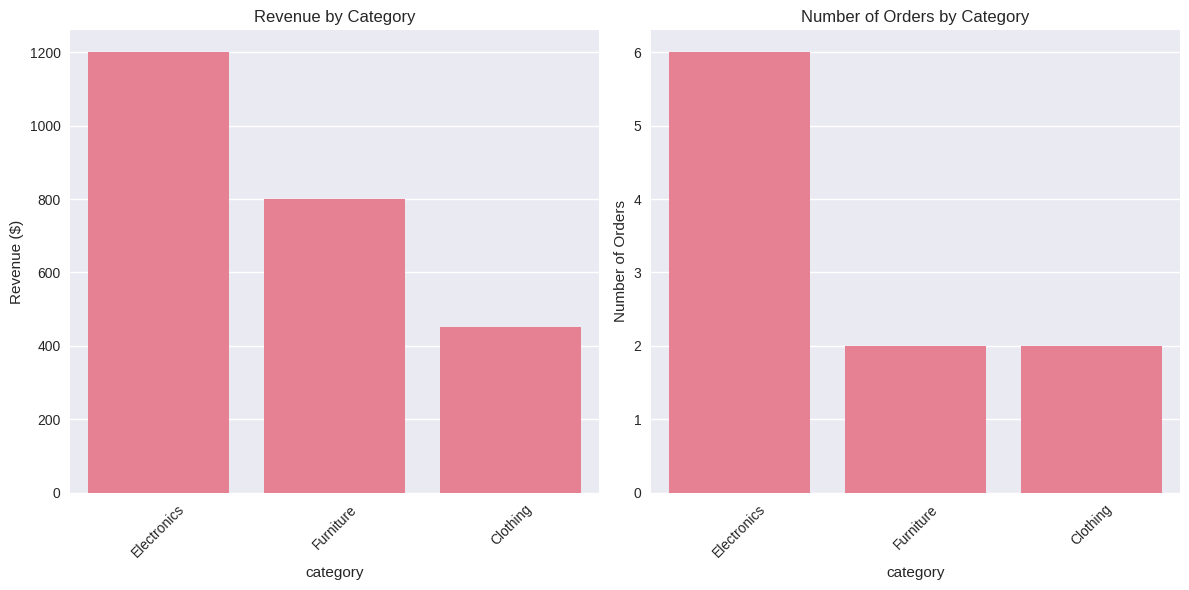

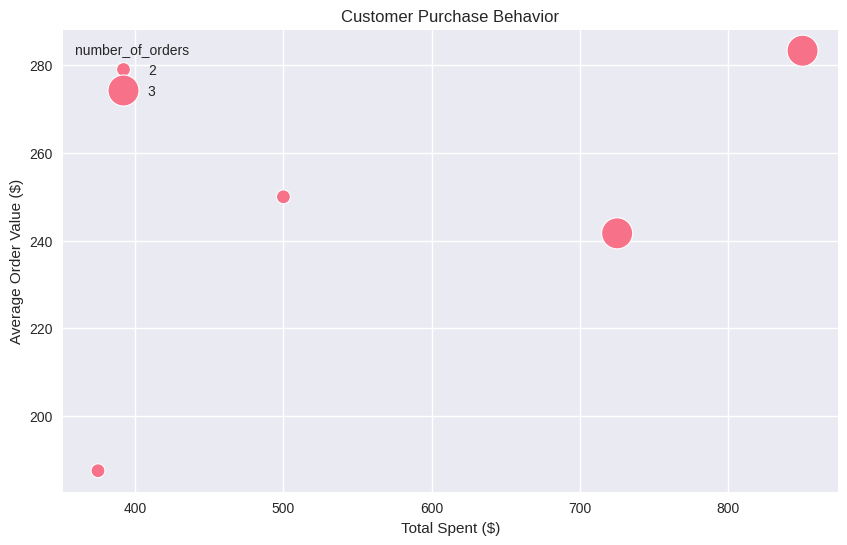

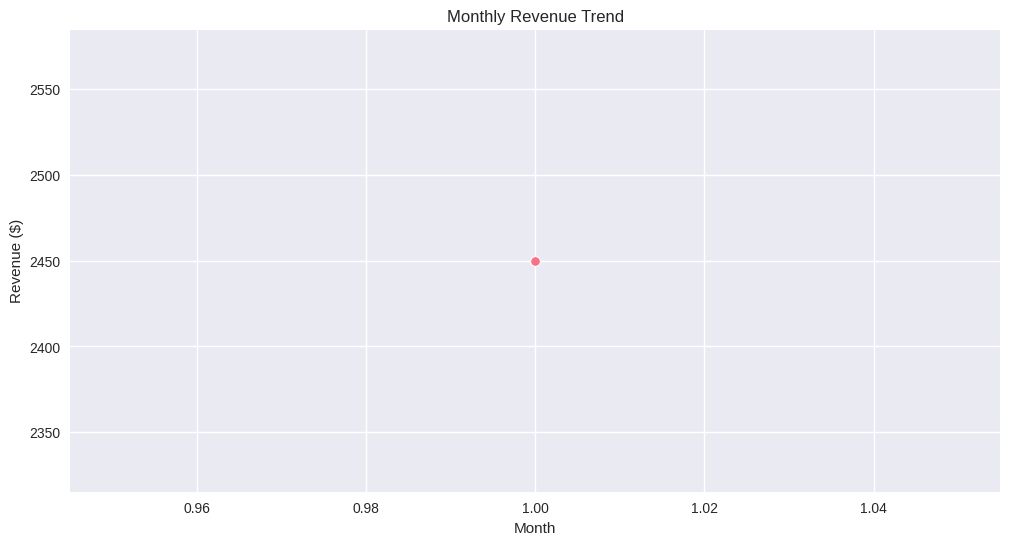

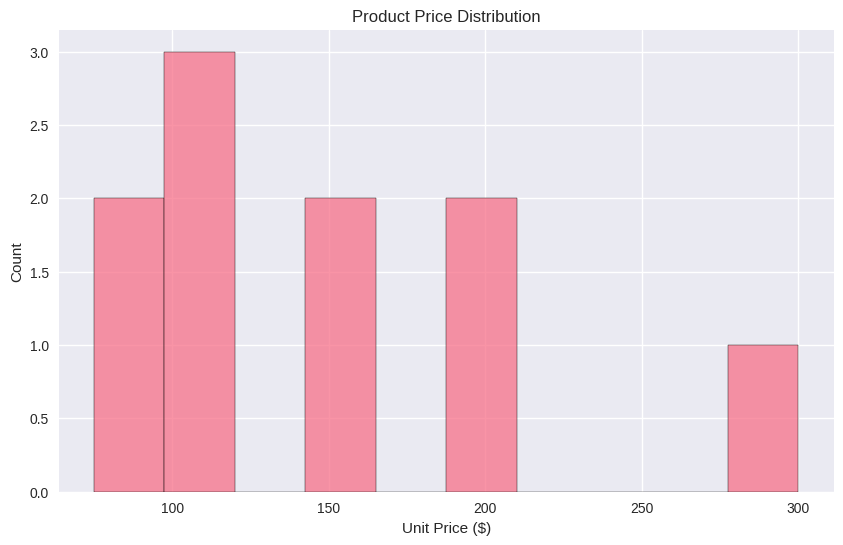

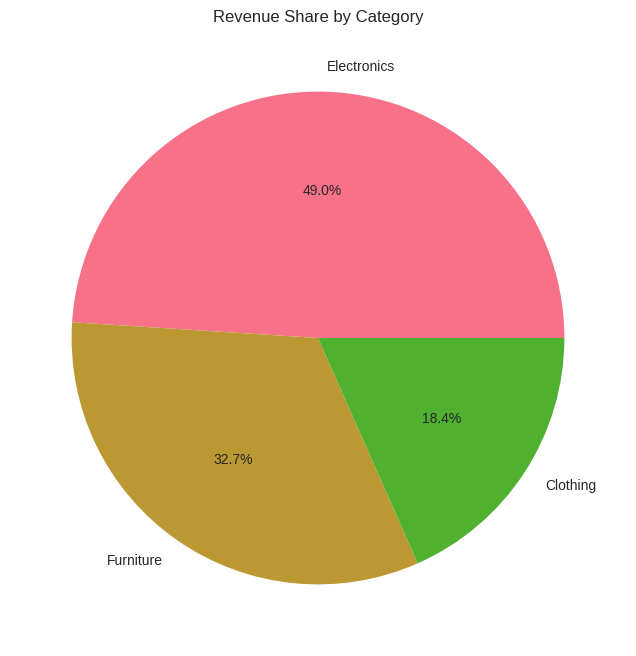

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, sum, desc, year, month, datediff, to_date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, DoubleType
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style for all visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Sales Analysis") \
    .getOrCreate()

# Define schema for the dataset
schema = StructType([
    StructField("order_id", StringType(), False),
    StructField("customer_id", StringType(), False),
    StructField("order_date", DateType(), False),
    StructField("product_id", StringType(), False),
    StructField("quantity", IntegerType(), False),
    StructField("unit_price", DoubleType(), False),
    StructField("category", StringType(), False)
])

# Create sample data with proper date objects
data = spark.createDataFrame([
    ("1", "C001", date(2024, 1, 1), "P1", 2, 100.0, "Electronics"),
    ("2", "C002", date(2024, 1, 2), "P2", 1, 150.0, "Clothing"),
    ("3", "C001", date(2024, 1, 3), "P3", 3, 75.0, "Electronics"),
    ("4", "C003", date(2024, 1, 4), "P1", 1, 100.0, "Electronics"),
    ("5", "C002", date(2024, 1, 5), "P4", 2, 200.0, "Furniture"),
    ("6", "C004", date(2024, 1, 6), "P2", 2, 150.0, "Clothing"),
    ("7", "C001", date(2024, 1, 7), "P5", 1, 300.0, "Electronics"),
    ("8", "C003", date(2024, 1, 8), "P4", 2, 200.0, "Furniture"),
    ("9", "C002", date(2024, 1, 9), "P1", 3, 100.0, "Electronics"),
    ("10", "C004", date(2024, 1, 10), "P3", 1, 75.0, "Electronics")
], schema)

def create_visualizations(analysis_results, df):
    """
    Create various visualizations for the analysis results
    """
    # Convert Spark DataFrames to Pandas for visualization
    category_data = analysis_results["category_analysis"].toPandas()
    customer_data = analysis_results["customer_analysis"].toPandas()
    time_data = analysis_results["time_analysis"].toPandas()

    # 1. Category Analysis Visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(data=category_data, x='category', y='revenue')
    plt.title('Revenue by Category')
    plt.xticks(rotation=45)
    plt.ylabel('Revenue ($)')

    plt.subplot(1, 2, 2)
    sns.barplot(data=category_data, x='category', y='number_of_orders')
    plt.title('Number of Orders by Category')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Orders')
    plt.tight_layout()
    plt.show()

    # 2. Customer Analysis Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=customer_data, x='total_spent', y='avg_order_value',
                    size='number_of_orders', sizes=(100, 500))
    plt.title('Customer Purchase Behavior')
    plt.xlabel('Total Spent ($)')
    plt.ylabel('Average Order Value ($)')
    plt.show()

    # 3. Time Series Analysis
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=time_data, x='month', y='monthly_revenue', marker='o')
    plt.title('Monthly Revenue Trend')
    plt.xlabel('Month')
    plt.ylabel('Revenue ($)')
    plt.show()

    # 4. Product Price Distribution
    plt.figure(figsize=(10, 6))
    price_data = df.select('unit_price').toPandas()
    sns.histplot(data=price_data, x='unit_price', bins=10)
    plt.title('Product Price Distribution')
    plt.xlabel('Unit Price ($)')
    plt.ylabel('Count')
    plt.show()

    # 5. Category Share Pie Chart
    plt.figure(figsize=(8, 8))
    plt.pie(category_data['revenue'], labels=category_data['category'], autopct='%1.1f%%')
    plt.title('Revenue Share by Category')
    plt.show()

def perform_sales_analysis(df):
    """
    Perform comprehensive sales analysis on the dataset
    """
    # 1. Basic data overview
    print("Dataset Overview:")
    df.printSchema()
    print(f"\nTotal Records: {df.count()}")

    # 2. Calculate sales metrics
    sales_metrics = df.withColumn("total_amount", col("quantity") * col("unit_price")) \
        .agg(
            count("order_id").alias("total_orders"),
            sum("total_amount").alias("total_revenue"),
            avg("total_amount").alias("avg_order_value")
        )

    # 3. Category-wise analysis
    category_analysis = df.withColumn("total_amount", col("quantity") * col("unit_price")) \
        .groupBy("category") \
        .agg(
            count("order_id").alias("number_of_orders"),
            sum("total_amount").alias("revenue"),
            avg("total_amount").alias("avg_order_value")
        ) \
        .orderBy(desc("revenue"))

    # 4. Customer purchase analysis
    customer_analysis = df.withColumn("total_amount", col("quantity") * col("unit_price")) \
        .groupBy("customer_id") \
        .agg(
            count("order_id").alias("number_of_orders"),
            sum("total_amount").alias("total_spent"),
            avg("total_amount").alias("avg_order_value")
        ) \
        .orderBy(desc("total_spent"))

    # 5. Time-based analysis
    time_analysis = df.withColumn("month", month("order_date")) \
        .withColumn("year", year("order_date")) \
        .groupBy("year", "month") \
        .agg(
            count("order_id").alias("number_of_orders"),
            sum(col("quantity") * col("unit_price")).alias("monthly_revenue")
        ) \
        .orderBy("year", "month")

    return {
        "sales_metrics": sales_metrics,
        "category_analysis": category_analysis,
        "customer_analysis": customer_analysis,
        "time_analysis": time_analysis
    }

analysis_results = perform_sales_analysis(data)

print("\nOverall Sales Metrics:")
analysis_results["sales_metrics"].show()

print("\nCategory-wise Analysis:")
analysis_results["category_analysis"].show()

print("\nCustomer Purchase Analysis:")
analysis_results["customer_analysis"].show()

print("\nTime-based Analysis:")
analysis_results["time_analysis"].show()


# Create the visualizations for the analysis
create_visualizations(analysis_results, data)


# Stop Spark session
spark.stop()